In [54]:
from sklearn.linear_model import SGDRegressor
from functools import lru_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from sklearn.datasets import make_classification
from sklearn.preprocessing import minmax_scale

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [56]:
age = np.random.normal(size=(1000))
age = minmax_scale(age, feature_range=(18, 90))
age

array([68.94346891, 63.37079631, 53.21667923, 44.92241558, 60.71300603,
       57.13574273, 63.02520005, 59.97285576, 64.83719818, 46.23366001,
       67.98133924, 54.83627507, 76.8778003 , 44.42643827, 72.89485351,
       54.83992794, 44.86981128, 46.83644105, 48.75619015, 57.49589628,
       58.65416014, 45.78212879, 52.23079499, 77.6644125 , 72.79600522,
       57.63861359, 52.96280507, 53.92571511, 59.71866539, 40.51031262,
       49.49539262, 32.92948318, 57.20309699, 60.11400494, 46.84465084,
       70.9934344 , 38.12764823, 35.32665788, 55.15148834, 64.80838628,
       72.28401103, 47.12992996, 65.17912788, 52.06464519, 50.49024855,
       62.88981294, 60.17418914, 34.01170738, 69.84952862, 68.71733134,
       45.17332198, 57.16295505, 58.31601992, 55.57669121, 46.05675669,
       44.63262417, 52.21671452, 66.28314249, 58.8979128 , 48.16611467,
       61.57552039, 19.07816371, 66.00184143, 32.09450447, 48.26206062,
       39.37308722, 37.31865799, 66.14342434, 47.02642951, 56.58

(array([ 12.,  25.,  79., 165., 247., 226., 147.,  69.,  25.,   5.]),
 array([18. , 25.2, 32.4, 39.6, 46.8, 54. , 61.2, 68.4, 75.6, 82.8, 90. ]),
 <BarContainer object of 10 artists>)

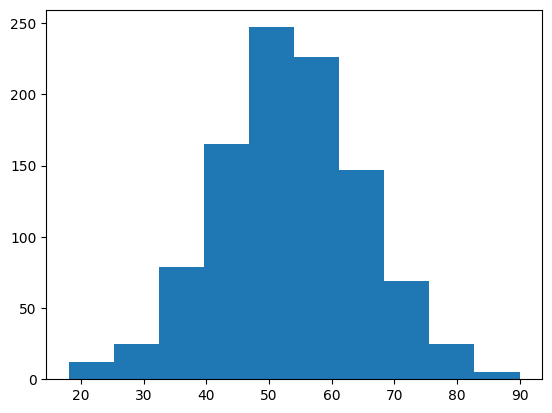

In [57]:
# plt.scatter(age_y, age)
plt.hist(age)